# Assignment 9: PyTorch

List your team members (name and immatriculation number) and indicate whether you are a B.Sc. Data Science or other group in the following cell:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- Group members:
  - Wang, Jiahui - B.Sc.Mathematik      - 2992080 
  - Zhao, Jiaqi  - M.Sc.Autonome System - 3470190 
  - Wang, Ziyin  - M.Sc.Informatik      - 3435397

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import skimage  # Package name: scikit-image, requires installation of package 'Pillow'
import skimage.io
import skimage.transform
import torch  # Package name: torch (for pip), pytorch (for conda)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

In [3]:
def load_airfoil_dataset():
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    
    data = np.genfromtxt('airfoil_self_noise.csv')
    X, y = data[:, :5], data[:, 5]
    y = y.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

    scaler_X = StandardScaler().fit(X_train)
    scaler_y = StandardScaler().fit(y_train)
    X_train = scaler_X.transform(X_train)
    X_test = scaler_X.transform(X_test)
    y_train = scaler_y.transform(y_train)
    y_test = scaler_y.transform(y_test)
    
    return X_train, X_test, y_train, y_test


def load_traffic_sign_dataset():
    import os
    
    def load_data(directory):
        directories = [d for d in os.listdir(directory)
                       if os.path.isdir(os.path.join(directory, d))]
        labels = []
        images = []
        for d in directories:
            label_directory = os.path.join(directory, d)
            file_names = [os.path.join(label_directory, f)
                          for f in os.listdir(label_directory)
                          if f.endswith(".ppm")]
            for f in file_names:
                images.append(skimage.io.imread(f))
                labels.append(int(d))
        images, labels = np.array(images), np.array(labels)
        images = np.array([skimage.transform.resize(img, (50, 50)) for img in images])
        return images, labels
            
    X_train, y_train = load_data('BelgiumTSC_Training/Training')
    X_test, y_test = load_data('BelgiumTSC_Testing/Testing')
    
    return X_train, X_test, y_train, y_test


In [4]:
class BasicDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, idx):
        return dict(X=self.X[idx], y=self.y[idx])
    
    def __len__(self):
        return self.X.shape[0]

    
class FlattenedImageDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = np.array([img.flatten() for img in X])
        self.y = y
        
    def __getitem__(self, idx):
        return dict(X=self.X[idx], y=self.y[idx])
    
    def __len__(self):
        return self.X.shape[0]


## Task 1: Linear Regression with SGD in PyTorch (35 Points)

In this first task, you will implement a linear regression model in PyTorch without using the existing [`torch.nn.Linear`](https://pytorch.org/docs/master/generated/torch.nn.Linear.html) module. Instead use basic math operations such as addition and matrix multiplication for the computation of the forward pass. The computation of gradients and performing backpropagation will be automatically handled by PyTorch.

Initialize the weights and bias of the linear model using the standard Gaussian distribution similar to Assignment 8 - Task 3. The `bias` parameter selects whether a bias term should be included in the model.

*Hint:* To allow training of the network, the weights of the model have to be made trainable. A convenient way to do this is to instantiate the learnable parameters as [`torch.nn.Parameter`](https://pytorch.org/docs/master/generated/torch.nn.parameter.Parameter.html) objects and set them as fields of a [`torch.nn.Module`](https://pytorch.org/docs/master/generated/torch.nn.Module.html) subclass.

In [5]:
class MyLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias
        
        # Your initialization code comes here.
        self.w = torch.nn.Parameter(torch.normal(0, 1, size=(in_features, out_features)))
        if self.bias:
            self.b = torch.nn.Parameter(torch.normal(0,1, size=(batch_size, out_features)).view(1,-1))
    
    def forward(self, X):
        # The forward pass of the linear regression comes here.
        # print('------------',X.shape, self.w.shape, self.b.shape)
        return X @ self.w + self.b


In [6]:
import os
dir = os.chdir(os.path.join('/content/drive', 'MyDrive', 'Colab Notebooks'))
os.listdir(dir)

['assignment1_solution (1).ipynb',
 'assignment1 (2).ipynb',
 'assignment1 (1).ipynb',
 'assignment1.ipynb',
 'numpy_tutorial.ipynb',
 '11.Python.ipynb',
 'assignment1_solution.ipynb',
 '13.Probability_CLT.ipynb',
 '15.Statistics.ipynb',
 'liar.txt',
 'Copy of assignment2.ipynb',
 'spamham.txt',
 'assignment2_solution.ipynb',
 'assignment2.ipynb',
 'assignment3_sol.ipynb',
 'assignment3.ipynb',
 'Untitled0.ipynb',
 'airfoil_self_noise.csv',
 '.ipynb_checkpoints',
 'BelgiumTSC_Training',
 'BelgiumTSC_Testing',
 'assignment9_sol.ipynb',
 'Assignment7-Bagging-Q.ipynb',
 'Assignment9-PytorchNN-Q.ipynb']

We provide you with the necessary code to train and compare your model and the reference implementation of PyTorch. You will have to replicate similar training code for multi-class classification in Task 2.

In [7]:
from sklearn.linear_model import LinearRegression

# Define hyperparameters
batch_size = 64
learning_rate = 0.01
epochs = 25
in_features = 5
out_features = 1

# Initialize models.
my_linear = MyLinear(in_features, out_features)
pt_linear = nn.Linear(in_features, out_features)
# print('----------0000',pt_linear)

# Load dataset.
X_train, X_test, y_train, y_test = load_airfoil_dataset()
dataset_train = BasicDataset(X_train, y_train)


def train_model(model, dataset, learning_rate, batch_size, epochs): 
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Train linear model using SGD on mini-batches.
    for epoch in range(epochs):
        # DataLoader generates random batches from a given dataset.
        data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)
         # We want to report the training loss after each epoch
        epoch_loss = 0.0 

        for batch in data_loader:
            # After each iteration of the training step, reset the local gradients stored in the network to zero.
            model.zero_grad()
            model.zero_grad()
            # print(f'{batch["X"].shape}, y: {batch["y"].shape}')

            # Compute the forward pass.
            # Numpy uses doubles by default but Torch expects floats, since the added accuracy of doubles 
            # is generally not useful for neural networks.
            # We fix this issue by changing the datatype of 'X' and 'y' with the .float method.
            yhat = model.forward(batch['X'].float())

            # Compute the batch error.
            batch_loss = F.mse_loss(yhat, batch['y'].float())
            epoch_loss += batch_loss.item()
            
            # Backpropagate the gradient and adjust the weights.
            batch_loss.backward()
            optimizer.step()
        
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss}')

        
def evaluate_model(model, X_test, y_test):
    X_test = torch.from_numpy(X_test).float()    
    yhat = model.forward(X_test).detach().numpy()
    mse = np.mean(np.power(yhat - y_test, 2))
    print('Test MSE:', mse)
    
    
print('MyLinear')
train_model(my_linear, dataset_train, learning_rate, batch_size, epochs)
evaluate_model(my_linear, X_test, y_test)
print()
print('torch.nn.Linear')
train_model(pt_linear, dataset_train, learning_rate, batch_size, epochs)
evaluate_model(pt_linear, X_test, y_test)
print()
print('sklearn.linear_model.LinearRegression')
print('Test MSE:', np.mean(np.power(LinearRegression().fit(X_train, y_train).predict(X_test) - y_test, 2)))

MyLinear


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch 1/25 - Loss: 62.34616446495056
Epoch 2/25 - Loss: 48.85617780685425
Epoch 3/25 - Loss: 40.731616497039795
Epoch 4/25 - Loss: 36.34377694129944
Epoch 5/25 - Loss: 33.69595718383789
Epoch 6/25 - Loss: 31.998674750328064
Epoch 7/25 - Loss: 30.774051189422607
Epoch 8/25 - Loss: 29.7841157913208
Epoch 9/25 - Loss: 29.2082701921463
Epoch 10/25 - Loss: 28.63953959941864
Epoch 11/25 - Loss: 28.23606252670288
Epoch 12/25 - Loss: 27.841825485229492
Epoch 13/25 - Loss: 27.4972060918808
Epoch 14/25 - Loss: 27.31278133392334
Epoch 15/25 - Loss: 26.93215775489807
Epoch 16/25 - Loss: 26.707961082458496
Epoch 17/25 - Loss: 26.477608799934387
Epoch 18/25 - Loss: 26.170341849327087
Epoch 19/25 - Loss: 26.011138439178467
Epoch 20/25 - Loss: 25.63205087184906
Epoch 21/25 - Loss: 25.575279474258423
Epoch 22/25 - Loss: 25.37372064590454
Epoch 23/25 - Loss: 25.12807810306549
Epoch 24/25 - Loss: 24.919549107551575
Epoch 25/25 - Loss: 24.73211634159088
Test MSE: 1.5088852891509497

torch.nn.Linear
Epoch 

## Task 2: Image Classification with FNN (35 Points)

In this task, you will implement an FNN for multi-class classification of traffic signs.

Download the [training](https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip) and [test](https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Testing.zip) data. Unpack the zip-files in the same directory as the Jupyter notebook.

The shape of each image is `(width=50, height=50, channels=3)` after resizing. The channels represent the color of each pixel.
FNN cannot directly operate on images. We therefore have to flatten each image to a vector.
We achieve this with the [`numpy.flatten`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html) method. The class `FlattenedImageDataset` may be used for training of your FNN.

Implement a feedforward neural network with multiple layers using either [`nn.Sequential`](https://pytorch.org/docs/master/generated/torch.nn.Sequential.html) class or by subclassing [`nn.Module`](https://pytorch.org/docs/master/generated/torch.nn.Module.html) as shown in Task 1.  Use a combination [`nn.Linear`](https://pytorch.org/docs/master/generated/torch.nn.Linear.html) and activation functions (e.g. [`nn.ReLU`](https://pytorch.org/docs/master/generated/torch.nn.ReLU.html)) to implement the fully connected layers of an FNN. Experiment with different activation functions (ReLU, tanh, ...), different depths, and widths. Use the Adam optimizer ([`optim.Adam`](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam)) for optimization.

You should evaluate your model by at least computing the relevant metrics (e.g. F1-score) and looking at a few misclassified samples.

*Note:* You may modify the code from Task 1. However, you need to use an appropriate loss function and output layer for your FNN to train your network for multi-class classification. Use your knowledge from the lecture to identify the correct methods in the [PyTorch documentation](https://pytorch.org/docs/stable/index.html).

In [8]:
# Load training and testing data.
X_train, X_test, y_train, y_test = load_traffic_sign_dataset()
print('Training samples:', X_train.shape[0])
print('Testing samples:', X_test.shape[0])
print('Image shape:', X_train[0].shape)
print('#Classes:', len(np.unique(y_train)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Training samples: 4575
Testing samples: 2520
Image shape: (50, 50, 3)
#Classes: 62


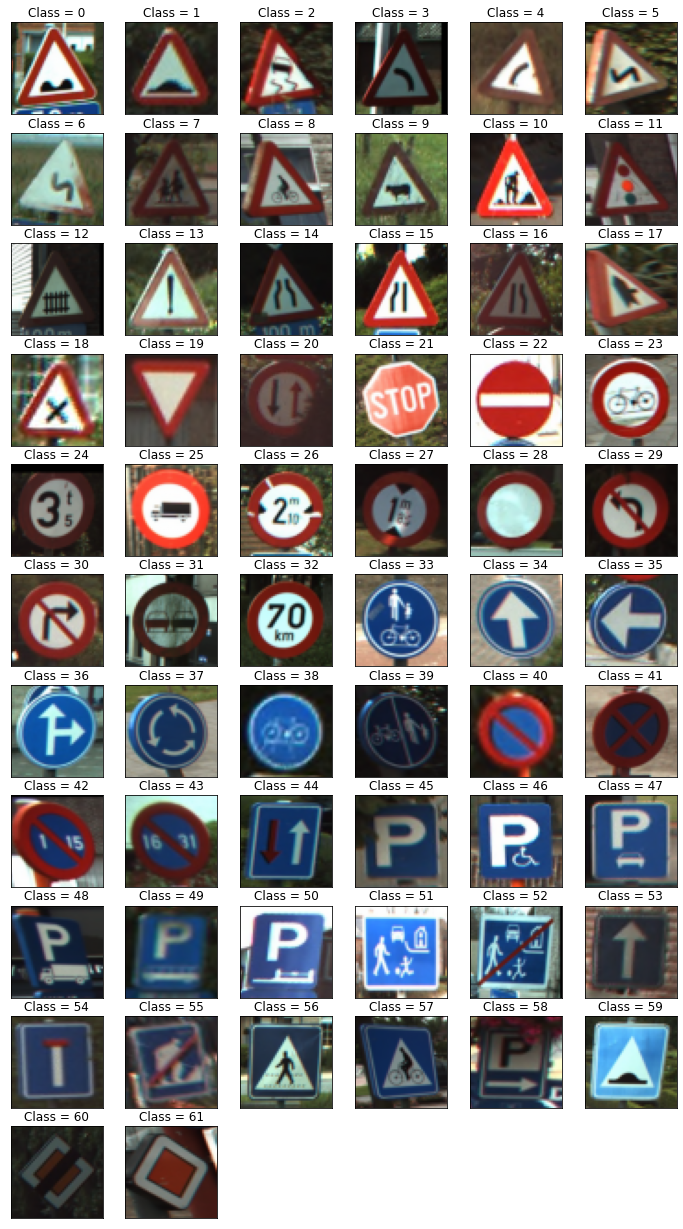

In [9]:
# Show sample for each class.
class_labels = set(np.unique(y_train))
n_classes = len(class_labels)

n_cols = 6
n_rows = n_classes // n_cols + 1
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
for label in sorted(class_labels):
    row = label // n_cols
    col = label % n_cols
    img_idx = np.argmax(y_train == label)
    ax[row, col].imshow(X_train[img_idx])
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])
    ax[row, col].set_title(f'Class = {label}')
    
leftover_subplots = n_cols - (max(class_labels) % n_cols) - 1
for i in range(leftover_subplots):
    fig.delaxes(ax[-1, -(i+1)])

In [10]:
# Implement your model and training here.
class FNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

def train_image(model, dataset, learning_rate, batch_size, epochs, device): 
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        epoch_loss = 0.0

        for batch in data_loader:
            model.zero_grad()
            model.zero_grad()

            yhat = model.forward(batch['X'].float().to(device))

            batch_loss = F.cross_entropy(yhat, batch['y'].long().to(device))
            epoch_loss += batch_loss.item()
            
            batch_loss.backward()
            optimizer.step()

        # if (epoch == 0) or (((epoch + 1) % 50) == 0):
        #     print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss}')
        if (epoch == 0) or (((epoch + 1) % 10) == 0):
            print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss}')

In [11]:
input_size = 50 * 50 * 3
hidden_size = 500
num_classes = 62
learning_rate = 0.01
batch_size = 300
epochs = 250

device = torch.device('cuda')
fnn = FNN(input_size, hidden_size, num_classes).to(device)
image_train = FlattenedImageDataset(X_train, y_train)

In [12]:
train_image(fnn, image_train, learning_rate, batch_size, epochs, device)

Epoch 1/250 - Loss: 223.16409635543823
Epoch 10/250 - Loss: 22.526078820228577
Epoch 20/250 - Loss: 16.875348448753357
Epoch 30/250 - Loss: 14.267800033092499
Epoch 40/250 - Loss: 11.931378185749054
Epoch 50/250 - Loss: 14.713862299919128
Epoch 60/250 - Loss: 13.430846452713013
Epoch 70/250 - Loss: 13.849903047084808
Epoch 80/250 - Loss: 9.856932580471039
Epoch 90/250 - Loss: 12.498912811279297
Epoch 100/250 - Loss: 9.389303863048553
Epoch 110/250 - Loss: 11.834929287433624
Epoch 120/250 - Loss: 10.594314068555832
Epoch 130/250 - Loss: 6.944811642169952
Epoch 140/250 - Loss: 7.980469197034836
Epoch 150/250 - Loss: 14.272834718227386
Epoch 160/250 - Loss: 6.793140530586243
Epoch 170/250 - Loss: 9.494180470705032
Epoch 180/250 - Loss: 6.093713849782944
Epoch 190/250 - Loss: 10.899928241968155
Epoch 200/250 - Loss: 5.947763741016388
Epoch 210/250 - Loss: 5.9314304292202
Epoch 220/250 - Loss: 15.141191869974136
Epoch 230/250 - Loss: 5.906910866498947
Epoch 240/250 - Loss: 10.05915310978889

In [13]:
# Implement your evaluation here
from sklearn.metrics import precision_recall_fscore_support

image_test = FlattenedImageDataset(X_test, y_test)
print(f'size: {image_test.__len__()}')
print(f'type of item: {type(image_test[0])}')
print(f'item[0]:\n  {image_test[0]}')

size: 2520
type of item: <class 'dict'>
item[0]:
  {'X': array([0.35555137, 0.25280627, 0.18739451, ..., 0.31764706, 0.19858824,
       0.13584314]), 'y': 54}


In [14]:
# Dataset to numpy-array
X = np.asarray([ image['X'] for image in image_test ])
y = np.asarray([ image['y'] for image in image_test ])
print(f'the shape of X: {X.shape}')
print(f'the shape of y: {y.shape}')
# numpy array to torch Tensor
X = torch.Tensor(X).to(device)
# y = torch.Tensor(y).to(device)
print(f'X: {X}')
print(f'y: {y}')

the shape of X: (2520, 7500)
the shape of y: (2520,)
X: tensor([[0.3556, 0.2528, 0.1874,  ..., 0.3176, 0.1986, 0.1358],
        [0.2871, 0.2245, 0.1696,  ..., 0.2730, 0.2270, 0.1786],
        [0.1500, 0.1208, 0.0778,  ..., 0.1659, 0.1320, 0.0922],
        ...,
        [0.0471, 0.0392, 0.0392,  ..., 0.0000, 0.0000, 0.0000],
        [0.4698, 0.5003, 0.4094,  ..., 0.2147, 0.2816, 0.1591],
        [0.1525, 0.1613, 0.1361,  ..., 0.4250, 0.5311, 0.5044]],
       device='cuda:0')
y: [54 54 54 ... 53 53 53]


In [15]:
with torch.no_grad():
    yhat = fnn(X)

shape of yhat: torch.Size([2520, 62])
yhat: (4, 62)


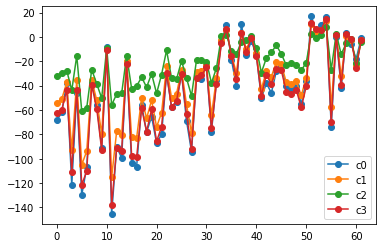

In [16]:
print(f'shape of yhat: {yhat.shape}')
yhat_arr = yhat.cpu().numpy()
print(f'yhat: {yhat_arr[:4].shape}')

for i, yi in enumerate(yhat_arr[:4]):
    plt.plot(yi, 'o-', label=f'c{i}');
plt.legend();


# yi_test = np.array([data['y'] for data in image_test])
# y_hat = fnn.forward(Xi_test).detach().numpy().argmax()
# prec, rec, f1, _ = precision_recall_fscore_support(yi_test, y_hat)

# print('Precision:', prec)
# print('Recall:', rec)
# print('F1-score:', f1)

In [17]:
yhat_label = yhat_arr.argmax(axis=-1)
idx = np.where(yhat_label == y)
print(f'yhat: {yhat_label.shape}, y: {y.shape}')

error, acc = 0, 0
for i in np.arange(y.shape[0]):
    yi, yi_hat = y[i], yhat_label[i]
    if yi != yi_hat:
        error += 1
print(f'#error: {error}')
acc = 1. - error / y.shape[0]
print(f'accuracy: {(acc * 100):>.4f}%')

from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1_score, _ = precision_recall_fscore_support(y, yhat_label, average='weighted')
print(f'precision: {precision:>.3f}')
print(f'recall: {recall:>.3f}')
print(f'f1-score: {f1_score:>.3f}')

yhat: (2520,), y: (2520,)
#error: 823
accuracy: 67.3413%
precision: 0.726
recall: 0.673
f1-score: 0.677


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Task 3: Image Classification with CNN (30 Points)

*For all students other than B.Sc. Data Science.*

In this task, you will implement a convolutional neural network (CNN) for classification of traffic signs.
Your model should use [`nn.Conv2d`](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) layers to compute convolutions, any kind of pooling (e.g. [`nn.MaxPool2d`](https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d)), and a dense output network.
For inspiration look at the architecture of AlexNet (presented in the lecture).
For simplicity, you may use the `nn.Sequential` class.

You should evaluate your model by at least computing the relevant metrics (e.g. F1-score) and looking at a few misclassified samples.

*Note:* For the most part, you can reuse your code from Task 2. However, you have to use images in their original format `(128, 128, 3)` instead of the flattened shape.

In [55]:
# Implement your model and training here.
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=96, kernel_size=3, padding=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.fc4 = nn.Linear(in_features=96*4*4, out_features=128)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(in_features=128, out_features=62)
    
    def forward(self, x):
        # print(f'x {x.shape}')
        yhat = self.conv1(x)
        # print(f'conv1 {yhat.shape}')
        yhat = self.pool1(yhat)
        # print(f'pool1 {yhat.shape}')
        yhat = self.conv2(yhat)
        # print(f'conv2 {yhat.shape}')
        yhat = self.pool2(yhat)
        # print(f'pool2 {yhat.shape}')
        yhat = self.conv3(yhat)
        # print(f'conv3 {yhat.shape}')
        yhat = self.pool3(yhat)
        # print(f'pool3 {yhat.shape}')
        yhat = yhat.view(-1, 96*4*4)
        # print(f'view -> {yhat.shape}')
        yhat = self.fc4(yhat)
        yhat = self.relu4(yhat)
        yhat = self.fc5(yhat)
        return yhat

In [19]:
def load_traffic_sign_ori_dataset():
    import os
    
    def load_data(directory):
        directories = [d for d in os.listdir(directory)
                       if os.path.isdir(os.path.join(directory, d))]
        labels = []
        images = []
        for d in directories:
            label_directory = os.path.join(directory, d)
            file_names = [os.path.join(label_directory, f)
                          for f in os.listdir(label_directory)
                          if f.endswith(".ppm")]
            for f in file_names:
                images.append(skimage.io.imread(f))
                labels.append(int(d))
        images, labels = np.array(images), np.array(labels)
        images = np.array([ skimage.transform.resize(img, (128, 128)) for img in images ])
        images = np.asarray([ np.stack((x[:,:,0], x[:,:,1], x[:,:,2]), axis=0) for x in images ])
        return images, labels

    X_train, y_train = load_data('BelgiumTSC_Training/Training')
    X_test, y_test = load_data('BelgiumTSC_Testing/Testing')
    
    return X_train, X_test, y_train, y_test

In [20]:
# Load training and testing data.
X_train, X_test, y_train, y_test = load_traffic_sign_ori_dataset()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [21]:
print('Training samples:', X_train.shape)
print('Testing samples:', X_test.shape)
print('Image shape:', X_train[0].shape)
print('#Classes:', len(np.unique(y_train)))

Training samples: (4575, 3, 128, 128)
Testing samples: (2520, 3, 128, 128)
Image shape: (3, 128, 128)
#Classes: 62


In [86]:
# Implement your evaluation here.
model = CNN().to(device)
train_dataset = BasicDataset(X_train, y_train)
lr = 1e-4
epoch = 40
batch_size = 32

train_dataset[0]['X'].shape

(3, 128, 128)

In [87]:
train_image(model=model, dataset=train_dataset, \
             learning_rate=lr, batch_size=batch_size, epochs=epoch, device=device)

Epoch 1/40 - Loss: 432.56192445755005
Epoch 10/40 - Loss: 9.716267496347427
Epoch 20/40 - Loss: 1.9585168606427033
Epoch 30/40 - Loss: 0.15717793962539872
Epoch 40/40 - Loss: 0.2914584843092598


In [88]:
dataset = BasicDataset(X_test, y_test)

# Dataset to numpy-array
X = np.asarray([ image['X'] for image in dataset ])
y = np.asarray([ image['y'] for image in dataset ])
print(f'the shape of X: {X.shape}')
print(f'the shape of y: {y.shape}')
# numpy array to torch Tensor
X = torch.Tensor(X).to(device)
# y = torch.Tensor(y).to(device)
print(f'X: {X.shape}')
print(f'y: {y.shape}')

with torch.no_grad():
    yhat = model(X)

the shape of X: (2520, 3, 128, 128)
the shape of y: (2520,)
X: torch.Size([2520, 3, 128, 128])
y: (2520,)


In [89]:
print(f'shape of yhat: {yhat.shape}')
yhat_arr = yhat.cpu().numpy()
print(f'yhat: {yhat_arr[:4].shape}')

yhat_label = yhat_arr.argmax(axis=-1)
idx = np.where(yhat_label == y)
print(f'yhat: {yhat_label.shape}, y: {y.shape}')

error, acc = 0, 0
for i in np.arange(y.shape[0]):
    yi, yi_hat = y[i], yhat_label[i]
    if yi != yi_hat:
        error += 1
print(f'#error: {error}')
acc = 1. - error / y.shape[0]
print(f'accuracy: {(acc * 100):>.4f}%')

precision, recall, f1_score, _ = precision_recall_fscore_support(y, yhat_label, average='weighted')
print(f'precision: {precision:>.3f}')
print(f'recall: {recall:>.3f}')
print(f'f1-score: {f1_score:>.3f}')

shape of yhat: torch.Size([2520, 62])
yhat: (4, 62)
yhat: (2520,), y: (2520,)
#error: 208
accuracy: 91.7460%
precision: 0.927
recall: 0.917
f1-score: 0.916


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
